# Ethereum Price Regression Using A Deep LSTM Based Network

Instead of using price percentage changes as features, here I will use raw price data as a feature set

This has some advantages:
1. Raw numerical price values might contain useful information lost when using price percentage changes
2. Regression allows us to hone in on specific values rather than simple binary increases or decreases, meaning the model will converge to more accurate predictions (in theory)

##### APIs Used: 

Crypto Control 
https://github.com/cryptocontrol/python-api

Crypto Data Download
https://www.cryptodatadownload.com/data/coinbase/

In [300]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch
import cryptocompare as crc
import datetime
import random

In [301]:
#read and clean data
ethData = pd.read_csv('Coinbase_ETHUSD_1h.csv', header = 1)
ethData['Close'] = ethData['Close'].replace(0, method='ffill')
ethPrices = ethData['Close'].to_numpy()

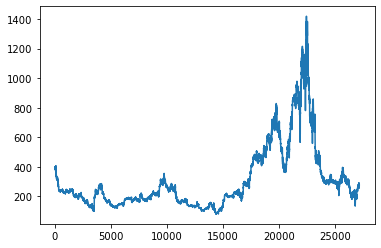

In [302]:
plt.plot(ethData['Close'])

In [303]:
prices = ethData['Close'].to_numpy()

targets = np.append(prices[1:], prices[-1])

print(prices[:5])
print(targets[:5])

print(prices.size, targets.size)

[396.12 394.97 399.52 399.68 397.69]
[394.97 399.52 399.68 397.69 392.8 ]
27149 27149


In [304]:
seq_len = 24
data=[]
for i in range(seq_len, prices.size):
    data.append((prices[i-seq_len:i], targets[i]))


In [305]:
real_prices = data[-3000:]#this will be used later to plot real data vs predicitons
data = data[:-3000]
random.shuffle(data)
data[0]

(array([182.78, 183.75, 184.28, 184.71, 185.45, 184.69, 185.31, 185.36,
        186.09, 185.81, 184.88, 184.77, 185.58, 184.78, 184.25, 184.34,
        185.67, 184.6 , 185.26, 185.92, 186.1 , 185.26, 185.99, 185.  ]),
 185.71)

In [306]:
n=len(data)
train=int(0.7*n)
valid=int(0.2*n)
test=int(0.1*n)

train_data=data[:train]
valid_data=data[train:train+valid]
test_data=data[-test:]

In [307]:
#TODO: fix error when specifying larger batch size than 1 --- FIXED
batch_size=64

trainLoader = torch.utils.data.DataLoader(train_data,batch_size = batch_size, shuffle=True)
validLoader = torch.utils.data.DataLoader(valid_data,batch_size = batch_size, shuffle=True)
testLoader = torch.utils.data.DataLoader(test_data,batch_size = batch_size, shuffle=True)

In [308]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

True


## LSTM based RNN model
Here I define the model with several LSTM layers, and 2 Linear layers. Hyperparameters were adjusted until the model with the lowest validation loss was chosen.

In [326]:
class rnn_model(nn.Module):
    def __init__(self, input_size, n_hidden, n_layers, n_out):
        super().__init__()
        
        self.n_hidden=n_hidden
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_size, n_hidden, n_layers, batch_first = True, dropout = 0.3)
        self.fcn1 = nn.Linear(n_hidden, 128)
        self.fcn2 = nn.Linear(128, n_out)#single value for regression
        
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x, hidden):
        #x input shape is (batch_size, seq_len, features)
        lstm_out, hidden = self.lstm(x)
        lstm_out = lstm_out.contiguous().view(-1,self.n_hidden) #reshape lstm output for fcl
        output=self.fcn1(lstm_out)
        output = self.dropout(output)
        output=self.fcn2(output)
        #sig_out = self.sig(output)
        #print(x.size(0))
        output = output.view(x.size(0),-1)
        return output[:,-1], hidden #return last prediction for each batch, and the hidden state
    
    def init_hidden(self,batch_size):
        
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden
        
rnn = rnn_model(1,64,2,1)
rnn

rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [327]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001, weight_decay=1e-3)

In [328]:

epochs=250
counter=0
clip=5 #gradient clipping to prevent exploding gradients common in lstms
print_every=200

train_losses=[]
valid_losses=[]

if train_on_gpu:
    rnn.cuda()
    
rnn.train()
for e in range(epochs):
    #initialize hidden state
    h = rnn.init_hidden(batch_size)
    print("Epoch", e)
    for inputs, labels in trainLoader:
        counter+=1
        
        #if cuda is available, push data to gpu
        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()
            
        #reshape inputs and convert to float
        inputs = inputs.float().unsqueeze(-1)
        #print(inputs.shape)
        #print(inputs, labels)
        #make new variables for hidden state so back propagation doesnt occur through entire hidden layer history
        h = tuple([each.data for each in h])
        
        #clear out gradients
        rnn.zero_grad()
        
        #get model output
        out, h = rnn(inputs, h)
        
        #print(out, labels.shape)
        #calc loss and perform backpropagation
        loss = criterion(out.squeeze(0),labels.float())
        loss.backward()
        
        train_losses.append(loss.item())
        
        nn.utils.clip_grad_norm_(rnn.parameters(), clip)
        optimizer.step()
        
        #every few loops, print the loss and accuracy metrics
        if counter % print_every == 0:
            val_h = rnn.init_hidden(batch_size)
            val_losses = []
            rnn.eval()
            for inputs, labels in validLoader:
                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()
                val_h = tuple([each.data for each in val_h])
                inputs = inputs.float().unsqueeze(-1)
                val_out, val_h = rnn(inputs, val_h)
                
                val_loss = criterion(val_out.squeeze(0), labels.float())
                val_losses.append(val_loss.item())
            print('..training loss: ', round(loss.item()))
            
            print('validation loss: ', round(np.mean(val_losses)))
            valid_losses.append(np.mean(val_losses))
            rnn.train()

Epoch 0
..training loss:  66702
validation loss:  52337
Epoch 1
..training loss:  13018
validation loss:  18961
Epoch 2
..training loss:  15690
validation loss:  10499
Epoch 3
..training loss:  5961
validation loss:  6134
..training loss:  3306
validation loss:  4402
Epoch 4
..training loss:  3162
validation loss:  3999
Epoch 5
..training loss:  1903
validation loss:  3233
Epoch 6
..training loss:  13135
validation loss:  3182
..training loss:  4075
validation loss:  2871
Epoch 7
..training loss:  680
validation loss:  2914
Epoch 8
..training loss:  2236
validation loss:  2727
Epoch 9
..training loss:  2436
validation loss:  2876
..training loss:  4848
validation loss:  2803
Epoch 10
..training loss:  611
validation loss:  2606
Epoch 11
..training loss:  1904
validation loss:  2612
Epoch 12
..training loss:  2574
validation loss:  2722
..training loss:  853
validation loss:  2659
Epoch 13
..training loss:  2966
validation loss:  2264
Epoch 14
..training loss:  2190
validation loss:  22

..training loss:  5701
validation loss:  1603
..training loss:  3933
validation loss:  1540
Epoch 119
..training loss:  1510
validation loss:  1751
Epoch 120
..training loss:  1528
validation loss:  1874
Epoch 121
..training loss:  1600
validation loss:  2094
..training loss:  444
validation loss:  1213
Epoch 122
..training loss:  3959
validation loss:  3354
Epoch 123
..training loss:  895
validation loss:  1553
Epoch 124
..training loss:  2787
validation loss:  1625
..training loss:  7393
validation loss:  3649
Epoch 125
..training loss:  1075
validation loss:  1908
Epoch 126
..training loss:  4709
validation loss:  1995
Epoch 127
..training loss:  3840
validation loss:  1249
Epoch 128
..training loss:  2615
validation loss:  2839
..training loss:  2279
validation loss:  1253
Epoch 129
..training loss:  1193
validation loss:  1689
Epoch 130
..training loss:  7669
validation loss:  5567
Epoch 131
..training loss:  2204
validation loss:  1728
..training loss:  537
validation loss:  1302

Epoch 235
..training loss:  897
validation loss:  2354
Epoch 236
..training loss:  3041
validation loss:  1501
Epoch 237
..training loss:  432
validation loss:  645
..training loss:  5376
validation loss:  2291
Epoch 238
..training loss:  2861
validation loss:  933
Epoch 239
..training loss:  3496
validation loss:  1379
Epoch 240
..training loss:  2355
validation loss:  1206
..training loss:  1045
validation loss:  1076
Epoch 241
..training loss:  3903
validation loss:  736
Epoch 242
..training loss:  460
validation loss:  827
Epoch 243
..training loss:  1849
validation loss:  3717
..training loss:  1341
validation loss:  862
Epoch 244
..training loss:  3275
validation loss:  1911
Epoch 245
..training loss:  2905
validation loss:  2412
Epoch 246
..training loss:  844
validation loss:  990
..training loss:  2903
validation loss:  2705
Epoch 247
..training loss:  812
validation loss:  2258
Epoch 248
..training loss:  813
validation loss:  896
Epoch 249
..training loss:  2017
validation l

best losses were 159 for validation with 3 layers of 64 nodes each with a sequence length of 24 hours

132.83700561523438


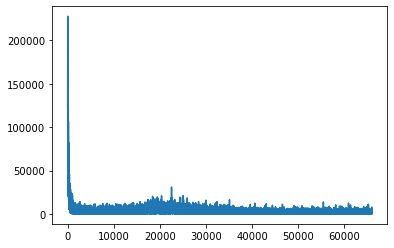

In [329]:
print(min(train_losses))
plt.plot(train_losses[:])

620.336811868768


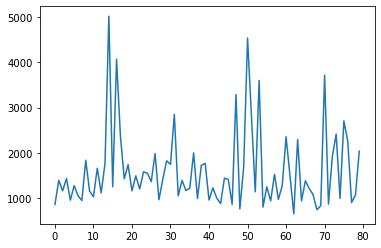

In [330]:
print(min(valid_losses))
plt.plot(valid_losses[250:])

In [331]:
tod = datetime.datetime.now()
test=crc.get_historical_price('ETH', 'USD',
                         timestamp=tod, exchange='Coinbase')

In [332]:
def get_past_days(num_days=5,curr='ETH'):
    tod = datetime.datetime.now()
    prices=[]
    for i in range(num_days+1,1,-1):
        d = datetime.timedelta(days = i)
        a = tod - d
        price=crc.get_historical_price(curr, 'USD',
                         timestamp=a, exchange='Coinbase')
        prices.append(price[curr]['USD'])
    return prices
p=get_past_days(seq_len + 1)
p

[245.88,
 264.28,
 275.68,
 279.59,
 305.66,
 311.35,
 322.24,
 317.59,
 318.16,
 335.31,
 346.86,
 387.4,
 372.21,
 386.22,
 389.82,
 401.21,
 395.28,
 379.75,
 397.51,
 390.41,
 395.78,
 378.88,
 387.27,
 424.94,
 438.83]

In [333]:
future = p[:]
#future = [121.83, 120.66, 122.  , 120.99, 122.76, 126.78, 127.43, 128.13,
#        127.16, 128.75, 130.3 , 131.35, 131.94, 131.67, 131.32, 131.12,
#        130.84, 130.79, 131.49, 131.43, 131.76, 132.24, 132.3 , 132.28]
#future.append(421.08)

#future = [393.71, 389.74, 390.87, 385.61, 380.49, 381.65, 384.97]

future = torch.Tensor(future)

In [334]:
rnn.eval()
future=future.float().view(1,-1,1)
prediction = rnn(future.cuda(), rnn.init_hidden(1))
print(prediction[0].item(), test['ETH']['USD'])
rnn.train()

366.2891845703125 427.78


rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [335]:
rnn.eval()
n=5000
correct = 0
hid = rnn.init_hidden(batch_size)
for sequence in data[:n]:
    inputs = torch.Tensor(sequence[0]).float().view(1,-1,1)
    labels = sequence[1]
    inputs = inputs.cuda()
    output, hid = rnn(inputs, hid)
    if int(output[0].item() >  sequence[0][-1]) == int(labels > sequence[0][-1]):
        correct += 1

print('Accuracy is: ', 100*correct / n, '%')
    
rnn.train()

Accuracy is:  50.96 %


rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [336]:
def conv_list(l, cuda):
    t = torch.Tensor(l).float().view(1,-1,1)
    if cuda:
        return t.cuda()
    return t

In [337]:
rnn.eval()
hid = rnn.init_hidden(batch_size)
predictions = []
real = []
for previous, target in real_prices:
    inputs = conv_list(previous, True)
    output, hid = rnn(inputs, hid)
    predictions.append(output[0].item())
    real.append(target)
rnn.train()  

rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

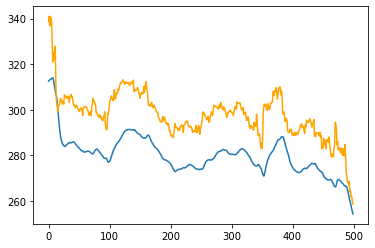

In [338]:
plt.plot(predictions[500:1000])
plt.plot(real[500:1000], color='orange')

## Predicting Bear or Bull Indicators

In [345]:
indicator_data = []
ahead = 5
for i in range(seq_len, prices.size-ahead):
    future_trend = prices[i + ahead] - prices[i]
    future_trend = int(future_trend > 0) #convert to 1 bit integer representing increase or decrease trend
    indicator_data.append((prices[i-seq_len:i], future_trend))
random.shuffle(indicator_data)

In [346]:
rnn.eval()
n=1000
correct = 0
hid = rnn.init_hidden(batch_size)
for sequence in indicator_data[:n]:
    tmp = sequence[0]
    labels = sequence[1]
    for i in range(ahead):
        inputs = conv_list(tmp, True)
        inputs = inputs.cuda()
        output, hid = rnn(inputs, hid)
        tmp = np.append(tmp[1:],output.item())
    pred_trend = int(output.item() - sequence[0][-1] > 0)
    if pred_trend == labels:
        correct += 1
print('Accuracy is: ', 100*correct / n, '%')
    
rnn.train()

Accuracy is:  51.6 %


rnn_model(
  (lstm): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fcn1): Linear(in_features=64, out_features=128, bias=True)
  (fcn2): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

Generate Fake Predicted Data

In [341]:
rnn.eval()
hid = rnn.init_hidden(batch_size)
seed = 25000
tmp = prices[seed:seed+seq_len]
fake_prices = []
for i in range(20):
        inputs = conv_list(tmp, True)
        inputs = inputs.cuda()
        output, hid = rnn(inputs, hid)
        tmp = np.append(tmp[1:],output.item())
        fake_prices.append(output.item())

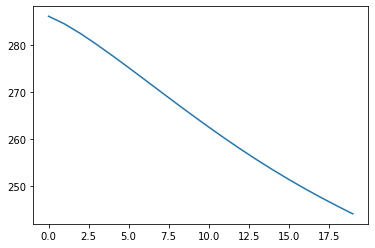

In [342]:
plt.plot(fake_prices)